In [1]:
import keras 
from keras import backend as K
from keras.models import load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

print('Done importing')

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Done importing


In [3]:
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.set_session(sess)

In [4]:
#Adding Seed so that random initialization is consistent
import os
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

In [5]:
import dataset

#Prepare input data
train_path='training_data'
classes = ['cats']
print(classes)
num_classes = len(classes)

# 10% of the data will automatically be used for validation
validation_size = 0.1
img_size = 32
num_channels = 3
sample_size = 8192

data = dataset.read_train_sets(train_path, img_size, ['cats'], validation_size=validation_size, sample_size=sample_size)


print("Complete reading input data. Will Now print a snippet of it")
print("Number of files in Training-set:\t\t{}".format(len(data.train.labels)))
print("Number of files in Validation-set:\t{}".format(len(data.valid.labels)))

['cats']
Going to read training images
Now going to read cats files (Index: 0)
Complete reading input data. Will Now print a snippet of it
Number of files in Training-set:		7373
Number of files in Validation-set:	819


In [6]:
x_train, _, _, _ = data.train.next_batch(7373)
x_valid, _, _, _ = data.valid.next_batch(819)

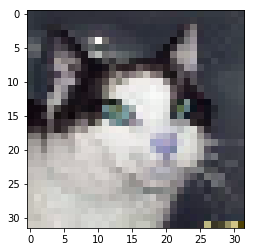

In [7]:
plt.imshow(x_valid[1].reshape(img_size, img_size, 3))

In [8]:
x_train = x_train.astype('float32')
x_valid = x_valid.astype('float32')
x_train /= 255
x_valid /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_valid.shape[0], 'test samples')

x_train shape: (7373, 32, 32, 3)
7373 train samples
819 test samples


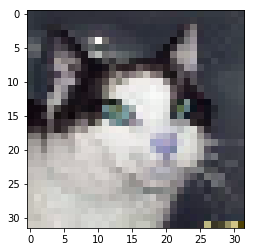

In [9]:
plt.imshow(255*x_valid[1].reshape(img_size, img_size, 3))

In [10]:
totLen = img_size * img_size * 3
midAct = 'relu'
finAct = 'sigmoid'
input_img = Input(shape=(img_size, img_size, 3))
x = Conv2D(64, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation(midAct)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation(midAct)(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), padding='same')(x)
print(x.shape)
x = BatchNormalization()(x)
x = Activation(midAct)(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
print('At this point the image is compressed by ' + str(totLen/1024))
x = Conv2D(16, (3, 3), padding='same')(encoded)
x = BatchNormalization()(x)
x = Activation(midAct)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation(midAct)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation(midAct)(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
decoded = Activation(finAct)(x)
#linear last layer for regression 

(?, 8, 8, 16)
At this point the image is compressed by 3.0


In [11]:
model = Model(input_img, decoded)
model.compile(optimizer='Adam', loss='binary_crossentropy)

In [12]:
es_cb = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='auto')
cp_cb = ModelCheckpoint('chkpt.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [13]:
history = model.fit(x_train, x_train,batch_size=16,epochs=25,verbose=1, 
                    validation_data=(x_valid, x_valid),
                    callbacks=[es_cb, cp_cb],
                    shuffle=True)

Train on 7373 samples, validate on 819 samples
Epoch 1/25
7373/7373 [==============================] - 11s 1ms/step - loss: 0.1847 - val_loss: 0.6205

Epoch 00001: val_loss improved from inf to 0.62054, saving model to chkpt.hdf5
Epoch 2/25
7373/7373 [==============================] - 7s 969us/step - loss: 0.1120 - val_loss: 0.7850

Epoch 00002: val_loss did not improve from 0.62054
Epoch 3/25
7373/7373 [==============================] - 7s 996us/step - loss: 0.0716 - val_loss: 0.3740

Epoch 00003: val_loss improved from 0.62054 to 0.37398, saving model to chkpt.hdf5
Epoch 4/25
7373/7373 [==============================] - 7s 979us/step - loss: 0.0483 - val_loss: 0.1422

Epoch 00004: val_loss improved from 0.37398 to 0.14215, saving model to chkpt.hdf5
Epoch 5/25
7373/7373 [==============================] - 7s 992us/step - loss: 0.0345 - val_loss: 0.4151

Epoch 00005: val_loss did not improve from 0.14215
Epoch 6/25
7373/7373 [==============================] - 7s 987us/step - loss: 0.02

In [14]:
score = model.evaluate(x_valid, x_valid, verbose=1)
print(score)

819/819 [==============================] - 0s 150us/step
0.00012873269926932308


In [15]:
recon = model.predict(x_valid)

In [16]:
# definition to show original image and reconstructed image
def showOrigDec(x_valid, recon, num=10):
    n = num
    plt.figure(figsize=(20, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i+1)
        plt.imshow(x_valid[i].reshape(img_size, img_size, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i +1 + n)
        plt.imshow(recon[i].reshape(img_size, img_size, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(819, 32, 32, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


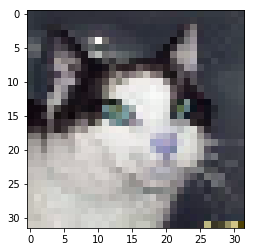

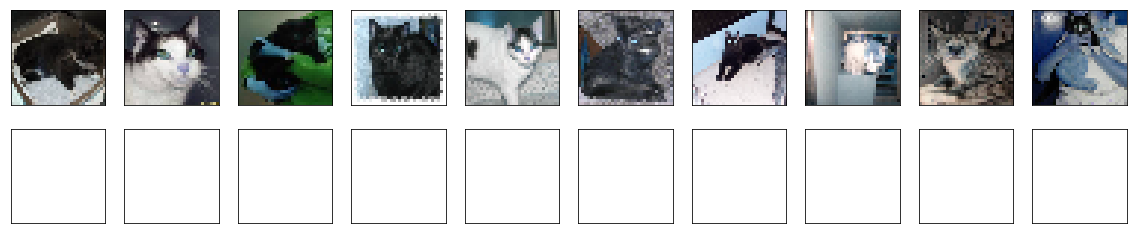

In [21]:
x_valid_ = 255*x_valid;
print(x_valid_.shape)
import matplotlib.pyplot as plt
plt.figure(figsize=(20,4))
plt.imshow(255*x_valid[1])
recon_ = 128*recon;
showOrigDec(x_valid_, recon_)

## Creating the AutoEncoder with three hidden layers

NameError: name 'plt' is not defined

In [22]:
print(recon)

[[[[0.01301822 0.01307136 0.0130736 ]
   [0.01301822 0.01307136 0.0130736 ]
   [0.01301822 0.01307136 0.0130736 ]
   ...
   [0.01301822 0.01307136 0.0130736 ]
   [0.01301822 0.01307136 0.0130736 ]
   [0.01301822 0.01307136 0.0130736 ]]

  [[0.01301822 0.01307136 0.0130736 ]
   [0.01301822 0.01307136 0.0130736 ]
   [0.01301822 0.01307136 0.0130736 ]
   ...
   [0.01301822 0.01307136 0.0130736 ]
   [0.01301822 0.01307136 0.0130736 ]
   [0.01301822 0.01307136 0.0130736 ]]

  [[0.01301822 0.01307136 0.0130736 ]
   [0.01301822 0.01307136 0.0130736 ]
   [0.01301822 0.01307136 0.0130736 ]
   ...
   [0.01301822 0.01307136 0.0130736 ]
   [0.01301822 0.01307136 0.0130736 ]
   [0.01301822 0.01307136 0.0130736 ]]

  ...

  [[0.01301822 0.01307136 0.0130736 ]
   [0.01301822 0.01307136 0.0130736 ]
   [0.01301822 0.01307136 0.0130736 ]
   ...
   [0.01301822 0.01307136 0.0130736 ]
   [0.01301822 0.01307136 0.0130736 ]
   [0.01301822 0.01307136 0.0130736 ]]

  [[0.01301822 0.01307136 0.0130736 ]
   [0.0

# visual